# Show Gap Image

This workbook was used to create images of gaps.
it consists of:
- the outlines of blobs before and after the gap
- a dotted line connecting the centroids of the two outlines
- a background image taken from sometime close to when the gap occured

an example of this is the image used in the bottom row of fig. 2b

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import division
import six, sys
sys.path.append('..'); import pathcustomize, about
about.about()

import random
import itertools

import pandas as pd
import numpy as np


from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.image as mpimg
import networkx as nx
#from IPython.core.display import Image as display_image

#os.environ.setdefault('MULTIWORM_SETTINGS', 'multiworm_settings')

#import waldo.wio as wio
#from waldo import multiworm
#from waldo.collider.viz import show_before_and_after

#import matplotlib.patches as patches
#from mpltools import style
#from mpltools import layout
#style.use('ggplot')

from waldo import wio
from waldo import collider
from waldo.images.manipulations import points_to_aligned_matrix

Python 2.7.9 (default, Apr 14 2015 12:54:25) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)] on linux2, Host: cody


In [3]:
ex_id = '20130702_135652'
experiment = wio.Experiment(experiment_id=ex_id)
prep_data = experiment.prepdata
graph = experiment.graph.copy()
cr = collider.CollisionResolver(graph=graph, experiment=experiment)


In [4]:
def find_closest_outline(nodes, experiment, closest_frame=None, use_first=True):
    outlines = []
    if use_first:
        it_step = 1
    else:
        it_step = -1
    
    for node in nodes:
        i = 0
        while True:
            try:
                outline = multiworm.readers.blob.decode_outline_line(experiment[node], i)
                outlines.append(outline)
                break
            except ValueError:
                pass
            i += it_step
    #print outlines
    return outlines

def find_mid_outline(node, experiment):
    outlines = []
    frames = []
    times = []
    
    bframes, btimes = zip(*[(int(l.split()[0]), float(l.split()[1])) for l in experiment._blob_lines(node)])
    
    
    # first just try to grab mid outline
    mid= int(len(btimes)/2)
    try:
        
        outline = multiworm.readers.blob.decode_outline_line(experiment[node], mid)
        time = btimes[mid]
        return time, outline
    except ValueError:
        pass
    
    # if that didn't work grab as many outlines as possible and return mid, working outline
    #print btimes
    for i in range(len(btimes)):    
        try:
            outline = multiworm.readers.blob.decode_outline_line(experiment[node], i)
            outlines.append(outline)
            times.append(btimes[i])
            frames.append(bframes[i])
        except ValueError:
            pass
    mid= len(times)/2
    
    return frames[mid], times[mid], outlines[mid]

def find_nearest_index(seq, value):
    """Return the index of the value in the sequence that is closest to the given value"""
    return (np.abs(np.array(seq)-value)).argmin()

def find_nearest(seq, value):
    """Return the value in the sequence that is closest to the given value"""
    return seq[find_nearest_index(seq, value)]

def frame_time(experiment, frame):
    """Return the time (in seconds) for the given frame from experiment"""
    return experiment.frame_times[int(frame) - 1]

def nearest_image(experiment, frame=None, time=None):
    if frame is None and time is None:
        raise ValueError("either the 'time' or 'frame' keyword argument must be provided")
    if time is None:
        time = frame_time(experiment, frame)
    
    image_time = find_nearest(list(six.iterkeys(experiment.image_files)), time)
    
    return experiment.image_files[image_time]

#find_mid_outline(node=513, experiment=e_pics)

In [5]:
def grab_outline(self, node, first=True, verbose=False):
    """
    return the first or last complete outline for a given node
    as a list of points.

    params
    -----
    node: (int or tuple)
       the id (from graph) for a node.
    graph: (networkx graph object)
       a directed graph of node interactions
    experiment: (multiworm experiment object)
       the experiment from which data can be exctracted.
    first: (bool)
       toggle that deterimines if first or last outline is returned

    returns
    ----
    outline: (list of tuples)
       a list of (x,y) points
    """
    graph = self._graph
    experiment = self._experiment
    nodes = [node]

    # older stuff that is suspected of being wrong.
    # preds = graph.predecessors(node)
    # while preds == 1:
    #     current = preds[0]
    #     nodes.insert(0, current)
    #     preds = graph.predecessors(current)

    # if first == True, we are dealing with a child of a collision.
    # then failure to locate an outline should search the successors.

    # invert this if first == False.

    if first:
        next_node = graph.successors
    else:
        next_node = graph.predecessors

    current = node
    backup_nodes = next_node(current)
    while len(backup_nodes) == 1:
        current=backup_nodes[0]
        nodes.append(current)
        backup_nodes = next_node(current)

    node_count = len(nodes)
    while len(nodes) > 0:
        node = nodes.pop(0)
        df = consolidate_node_data(graph, experiment, node)
        if df is None:
            print('Failed to find node data')
            #print('grabbing', node, type(node))
            raise CollisionException


        # if first ==True: sort chronologically. else sort in reverse.
        if first:
            df.sort(ascending=True, inplace=True)
        else:
            df.sort(ascending=False, inplace=True)

        for frame, row in df.iterrows():
            x, y = row['contour_start']
            l = row['contour_encode_len']
            enc = row['contour_encoded']
            bid = row['blob']
            is_good = True
            if not enc or not l:
                is_good = False
            if not isinstance(enc, basestring):
                is_good = False
            if is_good:
                # record which blob id the outline originated from
                if first:
                    # for children, we want first outline
                    self.child_node_to_blob[int(node)] = int(bid)
                else:
                    # for parents, we want last outline
                    self.parent_node_to_blob[int(node)] = int(bid)
                # return list of outline points
                outline_points = de.decode_outline([x, y, l, enc])
                return frame, outline_points
    if verbose:
        print('I: Failed to find outline in %d predeccessors' % node_count)
        print('I: grabbing', node, type(node))
    return None, None

In [6]:
def calc_bbox(bbox, size):
    xmin, ymin, xmax, ymax = bbox
    xmid = (xmin + xmax)/2.0
    ymid = (ymin + ymax)/2.0
    xmin = int(xmid - size[0]/2.0)
    xmax = int(xmid + size[0]/2.0)
    ymin = int(ymid - size[1]/2.0)
    ymax = int(ymid + size[1]/2.0) 
    return xmin, ymin, xmax, ymax
    
def format_fig(ax, bbox):
    xmin, ymin, xmax, ymax = bbox
    ax.set_xlim([0, xmax - xmin])
    ax.set_ylim([0,ymax - ymin])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

def adjust_xy(x, y, bbox):
    xmin, ymin, xmax, ymax = bbox
    x = np.array(x) - xmin
    y = np.array(y) - ymin
    return x, y

def get_cropped_img(experiment, time, bbox):
    xmin, ymin, xmax, ymax = bbox

    image_time = find_nearest(list(six.iterkeys(experiment.image_files)), time)
    print 'looking for', time, '| found', image_time, '| difference', np.abs(image_time-time)
    nearest_img = experiment.image_files[image_time]
    im = mpimg.imread(str(nearest_img))
    return im[xmin:xmax, ymin:ymax].T

def rescale_mask(m, mask_bbox, new_bbox):
    xmin, ymin, xmax, ymax = new_bbox

    xmin0, ymin0, xmax0, ymax0 = mask_bbox
    dxmin = xmin0 - xmin
    dymin = ymin0 - ymin
    #dxmax = xmax0 - xmax
    #dymax = ymax0 - ymax    
    mx, my = m.shape
    #     print 'bbox', new_bbox
    #     print 'mask', mask_bbox
    #     print 'd', dxmin, dymin #, dxmax, dymax
    #     print 'x', dxmin, 'to',  dxmin+mx, '=', mx
    #     print 'y', dymin, 'to', dymin+my, '=', my
    #     print new.shape
    #     print m.shape
    new = np.zeros(shape=(xmax - xmin, ymax -  ymin))

    
    #print new[dxmin:dxmin+mx, dymin:dymin+my].shape
    new[dxmin:dxmin+mx, dymin:dymin+my] = m
    #new[0:mx, 0:my] = m

    return new 


looking for 444.536 | found 444.63 | difference 0.094


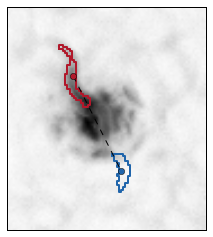

In [7]:
def quick_search(node1, node2, graph, experiment):

    frame0, o0 = cr.grab_outline(node1, first=False)
    frame1, o1 = cr.grab_outline(node2, first=True)

    # align outline masks
    outline_list = [o0, o1]

    masks, bbox = points_to_aligned_matrix(outline_list)
    box_width = max([100, 1 + max(masks[0].shape)])
    new_shape = (box_width, box_width)
    #print 'new shape', new_shape
    bbox2 = calc_bbox(bbox, size=new_shape)
    xmin, xmax, ymin, ymax = bbox2
    if xmin <0:
        xmin = 0
    if ymin <0:
        ymin = 0
    bbox2 = xmin, xmax, ymin, ymax
    
    next = 0
    #before, after = masks
    #print type(before)
    #print before.shape
    
    time0 = experiment.frame_times[frame0]
    time1 = experiment.frame_times[frame1]

    ################# colors
    cmap = plt.cm.Spectral
    cmap = plt.cm.RdBu
    color0=cmap(0.1)
    color1=cmap(0.9)
    
    
    ################# plots

    fig, ax = plt.subplots()
    x, y = zip(*o0)
    x, y = adjust_xy(x, y, bbox2)
    cx0, cy0 = np.mean(x), np.mean(y)
    ax.plot(x, y, lw=2, color=color0)

    x, y = zip(*o1)
    x, y = adjust_xy(x, y, bbox2)
    cx1, cy1 = np.mean(x), np.mean(y)
    ax.plot(x, y, lw=2, color=color1)
    
    ax.plot([cx0, cx1], [cy0, cy1], '--', color='black')
    ax.plot([cx0], [cy0], 'o', color=color0)
    ax.plot([cx1], [cy1], 'o', color=color1)
    
    im = get_cropped_img(experiment, time0, bbox2)
    ax.imshow(im, cmap=plt.cm.Greys_r)
    format_fig(ax, bbox2)
    plt.savefig('gap-{n1}-{n2}.png'.format(n1=n1, n2=n2))
    #plt.show()
    
n1, n2 = 3718, 3753
#n1, n2 = 4138,4189
#n1, n2 = 14015, 14053

quick_search(n1, n2, graph=graph, experiment=experiment)